# **Lid Driven Cavity**

In [1]:
import torch
import numpy as np
from torch import optim, autograd

In [2]:
import torch.nn as nn

In [3]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, input_dim, num_features):
        super(FourierFeatureLayer, self).__init__()
        self.B = nn.Parameter(torch.randn(input_dim, num_features)*10.0 , requires_grad=False)

    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class FourierFeatureNetwork(nn.Module):
    def __init__(self, input_dim, num_features, hidden_dim, output_dim):
        super(FourierFeatureNetwork, self).__init__()
        self.ff_layer = FourierFeatureLayer(input_dim, num_features)
        self.fc1 = nn.Linear(num_features * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.ff_layer(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x


In [4]:
input_dim = 2
num_features = 256
hidden_dim = 256
output_dim = 3

model = FourierFeatureNetwork(input_dim, num_features, hidden_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FourierFeatureNetwork(
  (ff_layer): FourierFeatureLayer()
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=3, bias=True)
)

In [5]:
xx, yy = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
import matplotlib.pyplot as plt

In [6]:
x = xx.reshape(-1,1)
y = yy.reshape(-1,1)

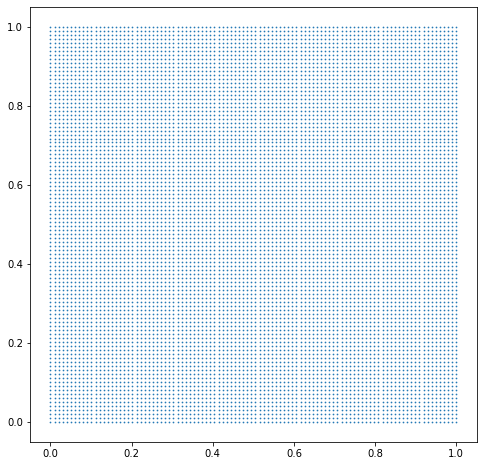

In [7]:
plt.figure(figsize=(8,8))
plt.scatter(x,y,s=0.5)

In [8]:


data_in = np.concatenate((x,y), axis =1)
data_in = torch.tensor(data_in, dtype=torch.float32).to(device)
data_in.requires_grad = True

u = np.zeros_like(x)
v = np.zeros_like(x)
p = np.zeros_like(x)

data_out = np.concatenate((u,v, p), axis =1)
data_out = torch.tensor(data_out, dtype=torch.float32).to(device)

In [9]:
L_funct = nn.MSELoss()

In [10]:
model(data_in)

tensor([[0.0437, 0.0388, 0.0525],
        [0.0435, 0.0428, 0.0537],
        [0.0391, 0.0391, 0.0541],
        ...,
        [0.0489, 0.0263, 0.0408],
        [0.0451, 0.0299, 0.0438],
        [0.0375, 0.0295, 0.0473]], grad_fn=<AddmmBackward0>)

In [11]:
data_in.requires_grad = True
output = model(data_in)
u_pred, v_pred, p_pred = output[:,[0]], output[:,[1]], output[:,[2]]
print(output.shape)
print(u_pred.shape)
u_xy = autograd.grad(outputs=u_pred, inputs=data_in, grad_outputs=torch.ones_like(u_pred), create_graph=True, retain_graph=True,)[0]
print(u_xy.shape)
u_x, u_y = u_xy[:,[0]], u_xy[:,[1]]


u_xxyy = autograd.grad(outputs=u_xy, inputs=data_in, grad_outputs=torch.ones_like(u_xy), create_graph=True, retain_graph=True,)[0]
print(u_xxyy.shape)
u_xx, u_yy = u_xxyy[:,[0]],u_xxyy[:,[1]]


torch.Size([10000, 3])
torch.Size([10000, 1])
torch.Size([10000, 2])
torch.Size([10000, 2])


In [12]:
def pinn_loss(model, x_train):
    x_train.requires_grad = True

    Re = torch.tensor(100.0)
    output = model(x_train)
    u_pred, v_pred, p_pred = output[:,[0]], output[:,[1]], output[:,[2]]


    u_xy = autograd.grad(outputs=u_pred, inputs=x_train, grad_outputs=torch.ones_like(u_pred), create_graph=True, retain_graph=True,)[0]
    u_x, u_y = u_xy[:,[0]], u_xy[:,[1]]

    v_xy = autograd.grad(outputs=v_pred, inputs=x_train, grad_outputs=torch.ones_like(v_pred), create_graph=True, retain_graph=True,)[0]
    v_x, v_y = v_xy[:,[0]], v_xy[:,[1]]


    p_xy = autograd.grad(outputs=p_pred, inputs=x_train, grad_outputs=torch.ones_like(p_pred), create_graph=True, retain_graph=True,)[0]
    p_x, p_y = p_xy[:,[0]], p_xy[:,[1]]

    u_xxyy = autograd.grad(outputs=u_xy, inputs=x_train, grad_outputs=torch.ones_like(u_xy), create_graph=True, retain_graph=True,)[0]
    u_xx, u_yy = u_xxyy[:,[0]],u_xxyy[:,[1]]

    v_xxyy = autograd.grad(outputs=v_xy, inputs=x_train, grad_outputs=torch.ones_like(v_xy), create_graph=True, retain_graph=True,)[0]
    v_xx, v_yy = v_xxyy[:,[0]], v_xxyy[:,[1]]

    # Navier-Stokes residuals
    mom_x = u_pred * u_x + v_pred * u_y - (1 / Re) * (u_xx + u_yy) + p_x
    mom_y = u_pred * v_x + v_pred * v_y - (1 / Re) * (v_xx + v_yy) + p_y
    cont = u_x + v_y

    # PINN loss
    loss_pinn = L_funct(mom_x, torch.zeros_like(mom_x)) + L_funct(mom_y, torch.zeros_like(mom_y)) + L_funct(cont, torch.zeros_like(cont))

    return loss_pinn

In [13]:
# Enforce the boundary conditions
def loss_top(model, top_train, top_bc_train):

    output = model(top_train)
    uv_pred = output[:,[0,1]]

    top_loss = L_funct(uv_pred, top_bc_train)

    return top_loss

In [14]:
# Enforce the boundary conditions
def loss_noslip(model, noslip_train, noslip_bc_train):

    output = model(noslip_train)
    uv_pred = output[:,[0,1]]

    noslip_loss = L_funct(uv_pred, noslip_bc_train)


    return noslip_loss

In [15]:
# Define the dimensions of the square domain
domain_size = 1.0

# Number of points on each wall
num_points_on_wall = 100

top_train = np.column_stack((np.linspace(0, domain_size, num_points_on_wall), np.full(num_points_on_wall, domain_size)))

left_wp = np.column_stack((np.zeros(num_points_on_wall - 1), np.linspace(0, domain_size, num_points_on_wall - 1)))

right_wp = np.column_stack((np.full(num_points_on_wall - 1, domain_size), np.linspace(0, domain_size, num_points_on_wall - 1)))

bottom_wp = np.column_stack((np.linspace(0, domain_size, num_points_on_wall - 2), np.zeros(num_points_on_wall - 2)))


noslip_train = np.vstack([left_wp, right_wp, bottom_wp])
# Generate random interior points
num_interior_points = 2000

x_train = np.random.rand(num_interior_points, 2) * domain_size

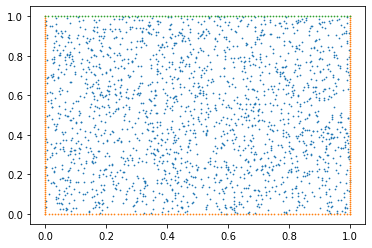

In [16]:
plt.scatter(x_train[:,0],x_train[:,1], s=0.5)
plt.scatter(noslip_train[:,0],noslip_train[:,1], s=0.5)
plt.scatter(top_train[:,0],top_train[:,1], s=0.5)

In [17]:
x_train = torch.tensor(x_train, dtype=torch.float32)
top_train = torch.tensor(top_train, dtype=torch.float32)
noslip_train = torch.tensor(noslip_train, dtype=torch.float32)
x_train = x_train.to(device)
top_train = top_train.to(device)
noslip_train = noslip_train.to(device)

In [18]:
top_bc_train = torch.vstack([torch.ones_like(top_train[:,0]),torch.zeros_like(top_train[:,0])]).T
noslip_bc_train = torch.vstack([torch.zeros_like(noslip_train[:,0]),torch.zeros_like(noslip_train[:,0])]).T
top_bc_train = top_bc_train.to(device)
noslip_bc_train = noslip_bc_train.to(device)

In [19]:
# import matplotlib.pyplot as plt
# plt.scatter(x_train[:,0],x_train[:,1], s=1, color = 'red')
# plt.scatter(top_train[:,0],top_train[:,1], s=1, color = 'green')
# plt.scatter(noslip_train[:,0],noslip_train[:,1], s=1, color = 'green')

In [20]:
# Training function
import torch.optim.lr_scheduler as lr_scheduler

def train_pinns(model, x_train, top_train, noslip_train, top_bc_train, noslip_bc_train, num_epochs=30000, lr=1e-3):
#    model.load_state_dict(torch.load('400.pth'))
    optimizer = optim.Adam(model.parameters(), lr=lr)

    
    # scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5000,15000], gamma=0.1)

    print(optimizer.state_dict())

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Compute PINN loss
        loss_pinn = pinn_loss(model, x_train)

        # Enforce boundary conditions
        top_loss = loss_top(model, top_train, top_bc_train)
        noslip_loss = loss_noslip(model, noslip_train, noslip_bc_train)

        # Total loss
        loss = loss_pinn + 2*noslip_loss + 2*top_loss

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # scheduler.step()
    
        if epoch % 100 == 0:
            torch.save(model.state_dict(), f"{epoch}.pth")
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()},PINN Loss: {loss_pinn.item()},Top Loss: {top_loss.item()}")

        if epoch%100==0:

            points = 400
            x= torch.linspace(0,1,points)
            y= torch.linspace(0,1,points)
            X,Y = torch.meshgrid(x.flatten(), y.flatten())
            
            x= torch.vstack([X.flatten(), Y.flatten()]).T
            x = x.to(device)
            # x = np.random.rand(num_interior_points, 2) * domain_size
            # x = torch.tensor(x, dtype=torch.float32)
            y = model(x)
            y = y.detach().cpu().numpy()
            x = x.detach().cpu().numpy()
            plt.figure(figsize=(6,5))
            plt.scatter(x[:, 0], x[:, 1], c=y[:, 0], s = 1, cmap = 'viridis')
            plt.colorbar()
            plt.axis("equal")
            plt.show()

{'state': {}, 'param_groups': [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]}
Epoch 0/30000, Loss: 9.604961395263672,PINN Loss: 8.687445640563965,Top Loss: 0.45719611644744873


/home/prashant/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


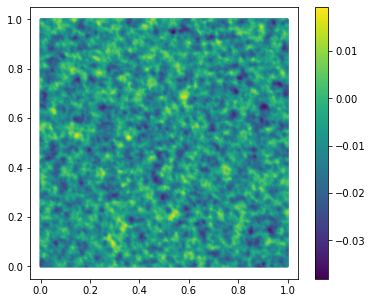

Epoch 100/30000, Loss: 0.523252546787262,PINN Loss: 0.023442739620804787,Top Loss: 0.15323346853256226


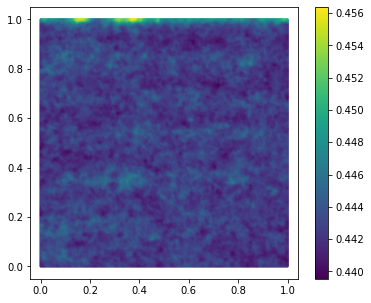

Epoch 200/30000, Loss: 0.5074630975723267,PINN Loss: 0.03209558129310608,Top Loss: 0.12231700867414474


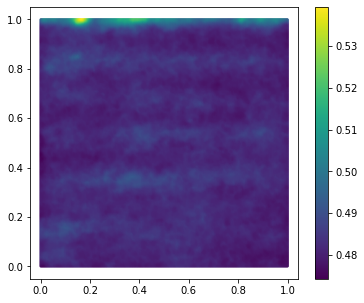

Epoch 300/30000, Loss: 0.3254123032093048,PINN Loss: 0.08616150170564651,Top Loss: 0.04081149399280548


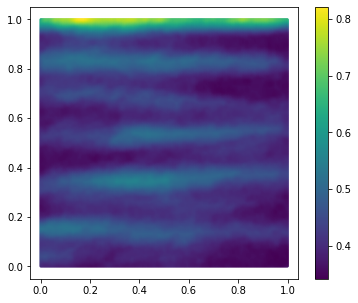

Epoch 400/30000, Loss: 0.13155445456504822,PINN Loss: 0.08243478089570999,Top Loss: 0.007336228620260954


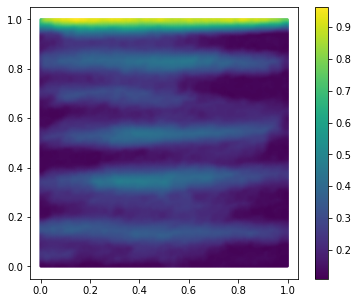

Epoch 500/30000, Loss: 0.07125025242567062,PINN Loss: 0.0496075302362442,Top Loss: 0.00296002090908587


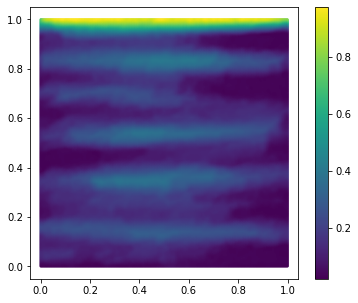

Epoch 600/30000, Loss: 0.05250685289502144,PINN Loss: 0.03641938045620918,Top Loss: 0.0017787213437259197


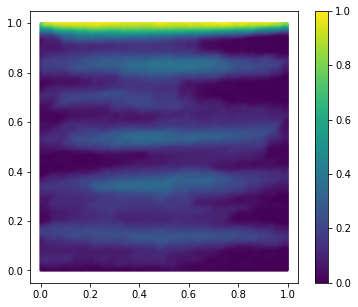

Epoch 700/30000, Loss: 0.04652680084109306,PINN Loss: 0.03215096518397331,Top Loss: 0.0015404002042487264


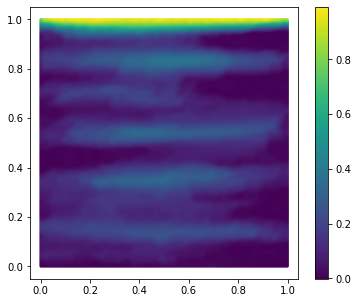

Epoch 800/30000, Loss: 0.038429632782936096,PINN Loss: 0.026271943002939224,Top Loss: 0.001151724485680461


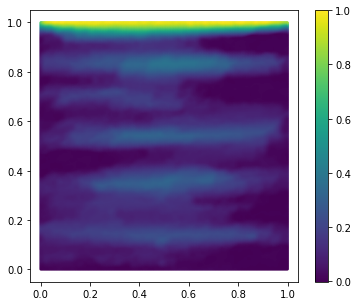

Epoch 900/30000, Loss: 0.03423337638378143,PINN Loss: 0.02268318086862564,Top Loss: 0.001339527778327465


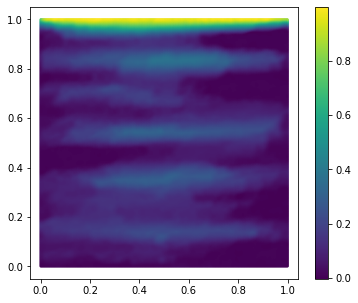

Epoch 1000/30000, Loss: 0.028619524091482162,PINN Loss: 0.018434420228004456,Top Loss: 0.0010207312880083919


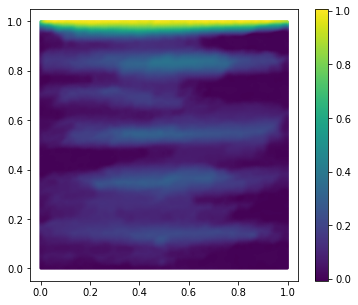

Epoch 1100/30000, Loss: 0.02688630297780037,PINN Loss: 0.017276069149374962,Top Loss: 0.0008417612407356501


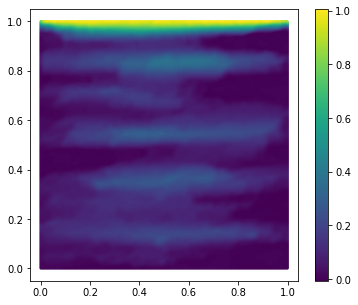

Epoch 1200/30000, Loss: 0.025788338854908943,PINN Loss: 0.016460813581943512,Top Loss: 0.0009455078979954123


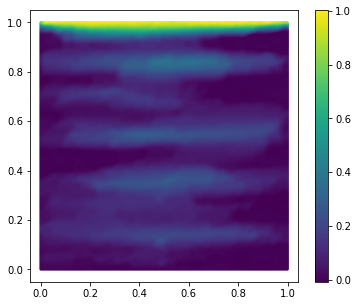

Epoch 1300/30000, Loss: 0.024754619225859642,PINN Loss: 0.01584283448755741,Top Loss: 0.0009198159677907825


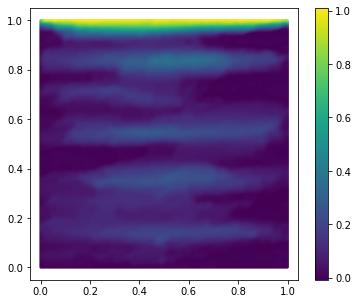

Epoch 1400/30000, Loss: 0.019786287099123,PINN Loss: 0.01153404638171196,Top Loss: 0.0008096006349660456


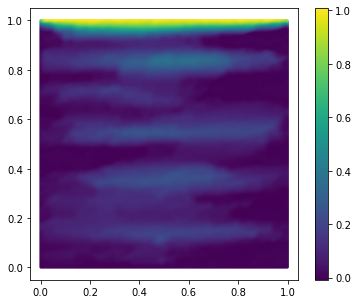

Epoch 1500/30000, Loss: 0.020443381741642952,PINN Loss: 0.01227292325347662,Top Loss: 0.0009610482957214117


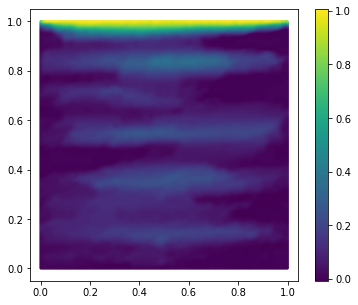

Epoch 1600/30000, Loss: 0.017845315858721733,PINN Loss: 0.010202683508396149,Top Loss: 0.0006933548138476908


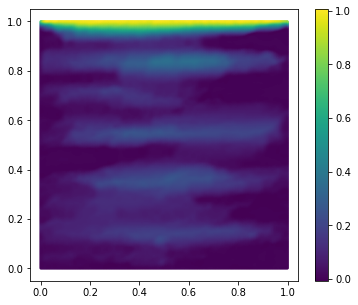

Epoch 1700/30000, Loss: 0.01790628768503666,PINN Loss: 0.010301422327756882,Top Loss: 0.0008136612013913691


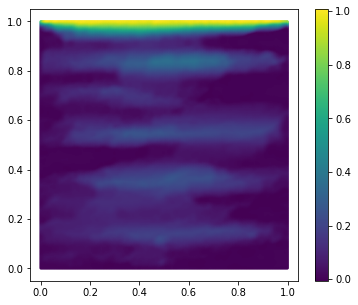

Epoch 1800/30000, Loss: 0.019989842548966408,PINN Loss: 0.012369217351078987,Top Loss: 0.0008593086968176067


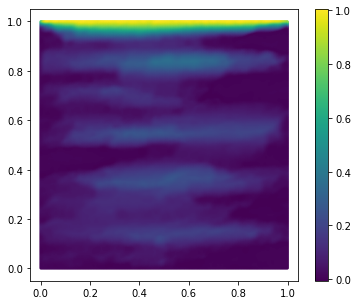

Epoch 1900/30000, Loss: 0.02618606761097908,PINN Loss: 0.018689492717385292,Top Loss: 0.0008966518798843026


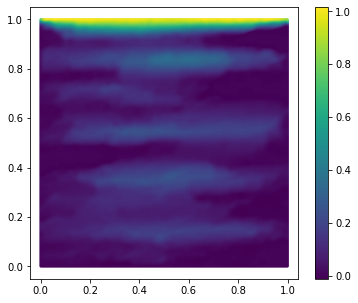

Epoch 2000/30000, Loss: 0.017630498856306076,PINN Loss: 0.010434702038764954,Top Loss: 0.0007738894200883806


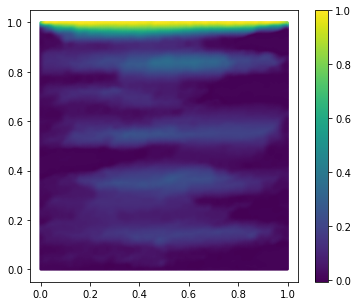

Epoch 2100/30000, Loss: 0.013671409338712692,PINN Loss: 0.006748533342033625,Top Loss: 0.0007544671534560621


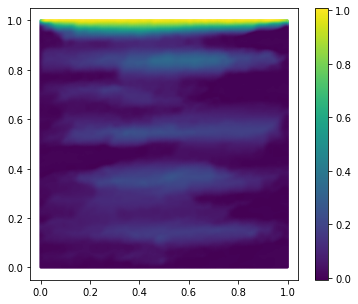

Epoch 2200/30000, Loss: 0.014804392121732235,PINN Loss: 0.00802596379071474,Top Loss: 0.0007422351627610624


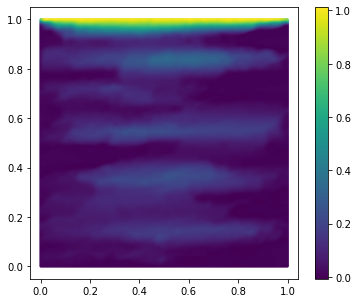

Epoch 2300/30000, Loss: 0.013304668478667736,PINN Loss: 0.006686774082481861,Top Loss: 0.0007312042871490121


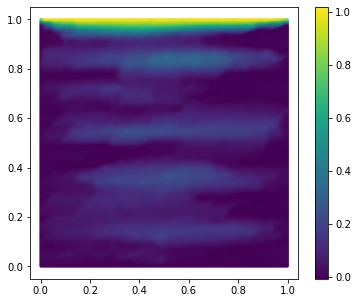

Epoch 2400/30000, Loss: 0.014227506704628468,PINN Loss: 0.007709956727921963,Top Loss: 0.0007025319500826299


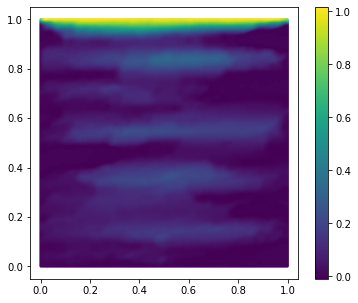

Epoch 2500/30000, Loss: 0.013801263645291328,PINN Loss: 0.007221798412501812,Top Loss: 0.0007244150619953871


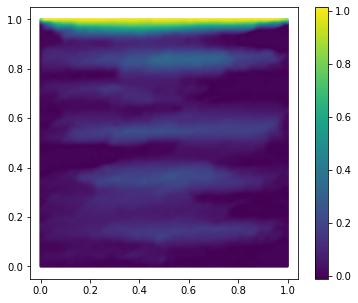

Epoch 2600/30000, Loss: 0.014295976608991623,PINN Loss: 0.00774308992549777,Top Loss: 0.000708164821844548


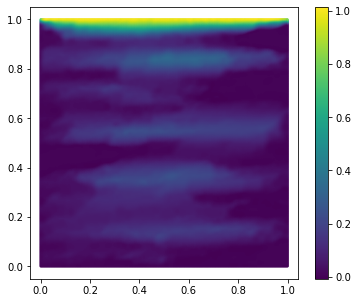

Epoch 2700/30000, Loss: 0.013539961539208889,PINN Loss: 0.007185165770351887,Top Loss: 0.0006706440472044051


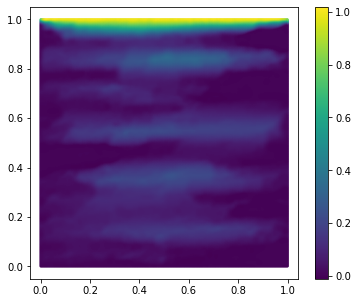

Epoch 2800/30000, Loss: 0.012457565404474735,PINN Loss: 0.006214833352714777,Top Loss: 0.0007090760627761483


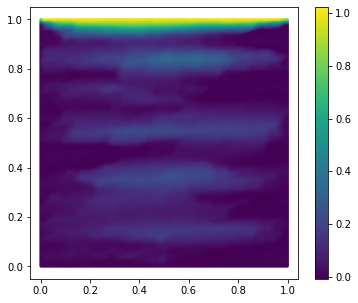

Epoch 2900/30000, Loss: 0.01224780734628439,PINN Loss: 0.00606248714029789,Top Loss: 0.0006982986815273762


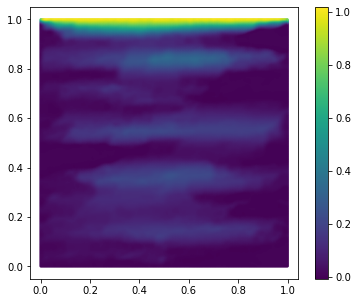

Epoch 3000/30000, Loss: 0.01464127004146576,PINN Loss: 0.008357016369700432,Top Loss: 0.0006860709399916232


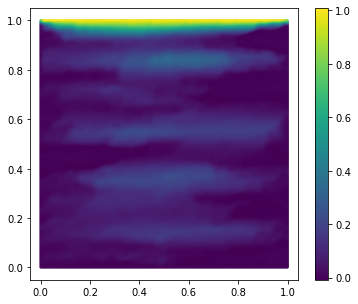

Epoch 3100/30000, Loss: 0.013045204803347588,PINN Loss: 0.006876680068671703,Top Loss: 0.0007150915917009115


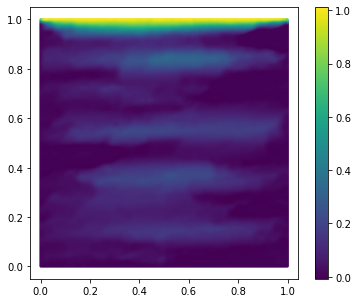

Epoch 3200/30000, Loss: 0.01238985639065504,PINN Loss: 0.006295849569141865,Top Loss: 0.0006858235574327409


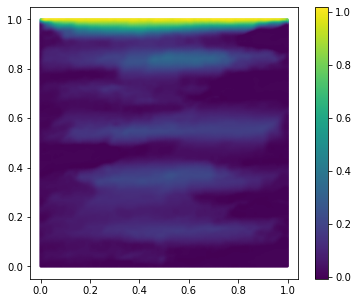

Epoch 3300/30000, Loss: 0.014037897810339928,PINN Loss: 0.007956897839903831,Top Loss: 0.000709628511685878


KeyboardInterrupt: 

In [21]:
train_pinns(model, x_train, top_train, noslip_train, top_bc_train, noslip_bc_train)

In [20]:
def train_pinns_lbfgs(model, x_train, top_train, noslip_train, top_bc_train, noslip_bc_train, max_iterations=5000):
    optimizer = optim.LBFGS(model.parameters(), lr=0.001, max_iter=max_iterations,
                            max_eval=None, tolerance_grad=1e-20,
                            tolerance_change=1e-15, history_size=1000,
                            line_search_fn="strong_wolfe")

    # optimizer = optim.LBFGS(model.parameters(), history_size=100, max_iter=5000)

    iteration = 0  # Rename 'iter' to 'iteration'
    
    def closure():
        nonlocal iteration  # Use nonlocal to reference the outer 'iteration' variable
        optimizer.zero_grad()

        # Compute PINN loss
        loss_pinn = pinn_loss(model, x_train)

        # Enforce boundary conditions
        top_loss = loss_top(model, top_train, top_bc_train)
        noslip_loss = loss_noslip(model, noslip_train, noslip_bc_train)

        # Total loss
        loss = loss_pinn + noslip_loss + top_loss

        # Backward
        loss.backward()

        iteration += 1
        
        if iteration % 10 == 0:
            print(f"Epoch {iteration}/{max_iterations}, Loss: {loss.item()}")

        return loss

    optimizer.step(closure)

# Example usage
train_pinns_lbfgs(model, x_train, top_train, noslip_train, top_bc_train, noslip_bc_train)

Epoch 10/5000, Loss: 0.002926190849393606
Epoch 20/5000, Loss: 0.002922559157013893
Epoch 30/5000, Loss: 0.0029126878362149
Epoch 40/5000, Loss: 0.0029097392689436674
Epoch 50/5000, Loss: 0.0029073432087898254
Epoch 60/5000, Loss: 0.0029070049058645964
Epoch 70/5000, Loss: 0.002906045876443386


In [21]:

points = 400
x= torch.linspace(0,1,points)
y= torch.linspace(0,1,points)
X,Y = torch.meshgrid(x.flatten(), y.flatten())

x= torch.vstack([X.flatten(), Y.flatten()]).T
x = x.to(device)
# x = np.random.rand(num_interior_points, 2) * domain_size
# x = torch.tensor(x, dtype=torch.float32)
y = model(x)
y = y.detach().cpu().numpy()
x = x.detach().cpu().numpy()

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


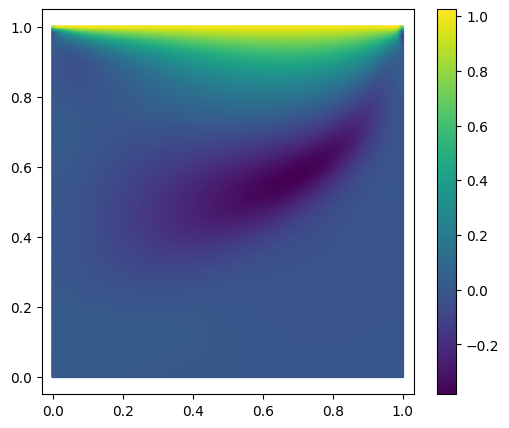

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.scatter(x[:, 0], x[:, 1], c=y[:, 0], s = 1, cmap = 'viridis')
plt.colorbar()
plt.axis("equal")
plt.show()

In [26]:
torch.save(model.state_dict(), 'ldc.pth')
